In [ ]:
#구글 드라이브 연결
from google.colab import drive
drive.mount('/content/gdrive')

#코랩 환경 경로 설정 -> 자신에게 맞는 경로로 설정해주시면 됩니다 
DATA_PATH = '/content/gdrive/MyDrive/미세먼지예측공모전/dataset/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

In [ ]:
import pandas as pd
import gc
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

from sklearn.preprocessing import LabelEncoder

import platform
# 차트에서 한글 출력을 위한 설정
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)


import torch
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더

device = torch.device('cuda')


gc.collect()

0

In [ ]:
df_tr = pd.read_csv(DATA_PATH + '/train.csv', encoding = "utf-8")
test = pd.read_csv(DATA_PATH + '/test.csv', encoding = "utf-8")

In [ ]:
df_tr.측정소.unique()

array(['공주', '노은동', '논산', '대천2동', '독곶리', '동문동', '모종동', '문창동', '성성동',
       '신방동', '신흥동', '아름동', '예산군', '읍내동', '이원면', '정림동', '홍성읍'],
      dtype=object)

In [ ]:
sub = pd.read_csv(DATA_PATH + '/answer_sample.csv')

___

* 지역별, 날짜별 데이터 수 확인

In [ ]:
df_tr['날짜'] = df_tr.일시.apply(lambda x : x[:5])
test['날짜'] = test.일시.apply(lambda x : x[:5])

In [ ]:
for i, r in enumerate(df_tr.측정소.unique().tolist()):
    a = df_tr.loc[df_tr.측정소 == r]
    print(r, a.날짜.nunique())

공주 366
노은동 366
논산 366
대천2동 366
독곶리 366
동문동 366
모종동 366
문창동 366
성성동 366
신방동 366
신흥동 366
아름동 366
예산군 366
읍내동 366
이원면 366
정림동 366
홍성읍 366


In [ ]:
for i, r in enumerate(test.측정소.unique().tolist()):
    a = test.loc[test.측정소 == r]
    print(r, a.날짜.nunique())

공주 320
노은동 320
논산 320
대천2동 320
독곶리 320
동문동 320
모종동 320
문창동 320
성성동 320
신방동 320
신흥동 320
아름동 320
예산군 320
읍내동 320
이원면 320
정림동 320
홍성읍 320


___

## Feature Extraction 

<ipython-input-10-512f2f37cd95>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_tr.corr(), annot = True)


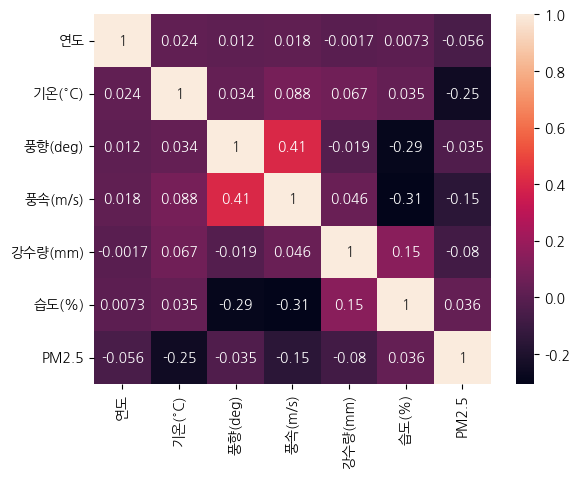

In [ ]:
sns.heatmap(df_tr.corr(), annot = True)
plt.show()

In [ ]:
# 측정소 encoding
enc = LabelEncoder()
df_tr['측정소'] = enc.fit_transform(df_tr['측정소'])

## DataLoader

* Split train/val

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
train = pd.DataFrame(columns = df_tr.columns[:-1])
val = pd.DataFrame(columns = df_tr.columns[:-1])

for r in tqdm(df_tr.측정소.unique().tolist()):
    a = df_tr.loc[df_tr.측정소 == r].reset_index().iloc[:,1:]
    for i in range(df_tr.연도.nunique()):
        b = a.loc[a.연도 == i]
        train_size = int(b.shape[0]*0.8)
        train_set = b.iloc[0:train_size,:-1].reset_index().iloc[:,1:]
        val_set = b.iloc[train_size:, :-1].reset_index().iloc[:,1:]
    
        train = pd.concat([train, train_set], axis = 0)
        val = pd.concat([val, val_set], axis = 0)

100%|██████████| 17/17 [00:02<00:00,  5.69it/s]


In [ ]:
train = train.drop(columns = '일시')
val = val.drop(columns = '일시')

In [ ]:
train = train.astype(float)
val = val.astype(float)

In [ ]:
train.shape, val.shape

((476867, 8), (119221, 8))

* Sliding Window

In [ ]:
seq_length = 2
output_dim = 3
batch_size = 48
def build_dataset(time_series, seq_length, output_dim):
    dataX = []
    dataY = []

    for r in tqdm(time_series.측정소.unique().tolist()):
        a = time_series.loc[time_series.측정소 == r].values
        for i in range(0, (a.shape[0]//((seq_length+output_dim)*24))*((seq_length+output_dim)*24), (seq_length+output_dim)*24):
            _x = a[i:i+seq_length*24, :]
            _y = a[i+seq_length*24:(i+seq_length*24)+output_dim*24, [-1]]

            dataX.append(_x)
            dataY.append(_y)
            
    return np.array(dataX), np.array(dataY)


trainX, trainY = build_dataset(train, seq_length, output_dim)
valX, valY = build_dataset(val, seq_length, output_dim)

100%|██████████| 17/17 [00:00<00:00, 712.32it/s]


In [ ]:
trainX.shape, trainY.shape, valX.shape, valY.shape

((3961, 48, 8), (3961, 72, 1), (986, 48, 8), (986, 72, 1))

In [ ]:
train_dataset = TensorDataset(torch.tensor(trainX, dtype=torch.float32).to(device), 
                              torch.tensor(trainY, dtype=torch.float32).to(device))

val_dataset = TensorDataset(torch.tensor(valX, dtype=torch.float32).to(device), 
                              torch.tensor(valY, dtype=torch.float32).to(device))

In [ ]:
train_dataloader = DataLoader(train_dataset,
                        batch_size=batch_size,
                        shuffle=False,  
                        drop_last=True)

val_dataloader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False,  
                        drop_last=True)

## Model

In [ ]:
# 설정값
data_dim = trainX.shape[2] # input feature
hidden_dim = 32
output_dim = 1
learning_rate = 0.01
nb_epochs = 200

In [ ]:
class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.layers = layers
        
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers,
                                  dropout=0.8,
                                  batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim, bias=True) 
        
    def reset_hidden_state(self, batch_size):
        self.hidden = (
            torch.zeros(self.layers, batch_size, self.hidden_dim, device=device),
            torch.zeros(self.layers, batch_size, self.hidden_dim, device=device))
    
    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        self.reset_hidden_state(batch_size)
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        x = self.fc(lstm_out)
        return x.view(batch_size, seq_len, self.output_dim)

In [ ]:
def train_model(model, train_df, num_epochs = None, lr = None, verbose = 10, patience = 10):
     
    criterion = torch.nn.MSELoss().to(device) # MAE loss로 학습해보기
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) # weight_decay : 규제항  / SGD / AdamW 
    nb_epochs = num_epochs
    
    # epoch마다 loss 저장
    train_hist = np.zeros(nb_epochs)
    for epoch in range(nb_epochs):
        avg_cost = 0
        total_batch = len(train_df)
        
        for batch_idx, samples in enumerate(train_df):

            x_train, y_train = samples
            batch_size = x_train.size(0)
            x_train = x_train.to(device)
            y_train = y_train.to(device)
            # seq별 hidden state reset
            model.reset_hidden_state(batch_size)

            
            # H(x) 계산
            outputs = model(x_train)
                
            # cost 계산
            loss = criterion(outputs, y_train)                    
            
            # cost로 H(x) 개선
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            avg_cost += loss/total_batch
               
        train_hist[epoch] = avg_cost        
        
        if epoch % verbose == 0:
            print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))
        '''
        # patience번째 마다 early stopping 여부 확인
        if (epoch % patience == 0) & (epoch != 0):
            
            # loss가 커졌다면 early stop
            if train_hist[epoch-patience] < train_hist[epoch]:
                print('\n Early Stopping')
                
                break
        '''
            
    return model.eval(), train_hist

In [ ]:
# 모델 학습
net = Net(data_dim, hidden_dim, 72, output_dim, 1).to(device)  
net

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Net(
  (lstm): LSTM(48, 32, batch_first=True, dropout=0.8)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
model, train_hist = train_model(net, train_dataloader, num_epochs = nb_epochs, lr = learning_rate, verbose = 20, patience = 10)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([48, 72, 1])) that is different to the input size (torch.Size([48, 8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: ignored

In [ ]:
# epoch별 손실값
fig = plt.figure(figsize=(10, 4))
plt.plot(train_hist, label="Training loss")
plt.title('loss')
plt.legend()
plt.show()

In [ ]:
# 모델 저장    
PATH = "./model.pth"
torch.save(model.state_dict(), PATH)

'''
# 불러오기
model = Net(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)
model.load_state_dict(torch.load(PATH), strict=False)
model.eval()
'''

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Net(
  (lstm): LSTM(8, 32, batch_first=True, dropout=0.8)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
def evaluate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            y_pred = model(x_val)
            loss = criterion(y_pred, y_val)
            val_loss += loss.item() * x_val.size(0)

    val_loss /= len(val_loader.dataset)
    
    
    model.train()

    print('Validation MSE: {:.4f}'.format(val_loss))

# 모델의 성능 평가
criterion = torch.nn.MSELoss().to(device)
evaluate_model(net, val_dataloader, criterion)

Validation MSE: 0.0048


/opt/conda/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([48, 72, 1])) that is different to the input size (torch.Size([48, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
